In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import scipy.io
from pyDOE import lhs
np.random.seed(1234)

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 20
        self.net = nn.Sequential(
            nn.Linear(2, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

In [3]:
def u_function(x, t):
    u = model(torch.hstack((x, t)))
    return u

def f_function(x, t, l):
    l1 = 1
    l2 = l
    u = u_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    return u_t + l1 * u * u_x - l2 * u_xx

def PINN(u, x_u, t_u, x_f, t_f, l):
    u_pre = u_function(x_u, t_u)
    f_pre = f_function(x_f, t_f, l)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    ls = u_loss + f_loss
    ls.backward()
    return ls

In [4]:
def gu_function(x, t):
    u = model(torch.hstack((x, t)))
    return u

def gf_function(x, t, l):
    l1 = 1
    l2 = l
    u = gu_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    u_xxt = torch.autograd.grad(u_xx, t, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    u_tx = torch.autograd.grad(u_t, x, torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_xt = torch.autograd.grad(u_x, t, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    f = u_t + l1 * u * u_x - l2 * u_xx
    f_t = u_tt + l1 * (u_t * u_x + u * u_xt) - l2 * u_xxt
    f_x = u_tx + l1 * (u_x * u_x + u * u_xx) - l2 * u_xxx
    return f, f_t, f_x

def gPINN(u, x_u, t_u, x_f, t_f, l):
    u_pre = gu_function(x_u, t_u)
    f_pre, f_t, f_x = gf_function(x_f, t_f, l)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    ft_loss = loss_fn(f_t, null)
    fx_loss = loss_fn(f_x, null)
    ls = u_loss + f_loss + 0.0001 * ft_loss + 0.0001 * fx_loss
    ls.backward()
    return ls
    

In [5]:
def get_data(n):
    data = np.load("C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\gpinn-main\\src\\Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    
    size = min(n, len(X))
    
    index = np.random.choice(len(X), size=size, replace=False)
    xnp = X[:,0][index].reshape(-1,1)
    tnp = X[:,1][index].reshape(-1,1)
    Unp = y[index].reshape(-1,1)
    sorted_index = np.argsort(index)
    return xnp[sorted_index],tnp[sorted_index],Unp[sorted_index]

In [6]:
# 制造数据点集，要求区分边界点X_u_train和内点X_f_train
nu = 0.01 / np.pi
N_u = 100
N_f = 10000
n = 2000
# 边界点X_u_train
x_upper = np.ones((N_u//4, 1), dtype=float)
x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=float)

t_upper = np.random.rand(N_u//4, 1)
t_lower = np.random.rand(N_u//4, 1)
x_zero = np.random.rand(N_u//2, 1) * 2 - 1 # 从0，1映射到-1，1

X_upper = np.hstack((x_upper, t_upper)) # 按列拼接
X_lower = np.hstack((x_lower, t_lower))
X_zero = np.hstack((x_zero, t_zero))

X_u_train = np.vstack((X_upper, X_lower, X_zero)) # 按行拼接

index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :] # 打乱训练集

xx,tt,uu = get_data(n)
in_train = np.hstack((xx,tt))
X_u_train = np.vstack((in_train,X_u_train))

# 内点X_f_train
X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-1, 1)
    t = uniform( 0, 1)
    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t
X_f_train = np.vstack((X_f_train, X_u_train))

# 边界条件u_train
u_upper =  np.zeros((N_u//4, 1), dtype=float)
u_lower =  np.zeros((N_u//4, 1), dtype=float) 
u_zero = -np.sin(np.pi * x_zero)  

u_train = np.vstack((u_upper, u_lower, u_zero))
u_train = u_train[index, :] # 对应X_u_train顺序

u_train = np.vstack((uu,u_train))

In [7]:
# 模型训练
Losses = []
L = []
l_epochs = 200

model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
l = torch.nn.Parameter(torch.tensor([0.01], dtype=torch.float32, requires_grad=True))

x_u = torch.tensor(X_u_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_u = torch.tensor(X_u_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

u = torch.tensor(u_train, dtype=torch.float32)

file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_Burgers_Inverse.pkl'
if os.path.exists(file_name) and os.path.isfile(file_name):
    loading_model = False
    if loading_model == True:
        model.load_state_dict(torch.load(file_name))
        print('loading model')
    else:
        print('no model loading')
        
def train(epochs, Losses = [], loss1 = 100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
    optimizer_l = torch.optim.Adam([l], lr=0.001)
    scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, step_size=400, gamma=0.1)
    for epoch in range(epochs):
        optimizer.zero_grad()
        optimizer_l.zero_grad()
        loss = gPINN(u, x_u, t_u, x_f, t_f, l)
        if torch.abs(loss1 - loss) / loss1 < 1e-8:
            print(f"[Epoch {epoch}/{epochs}] [loss: {loss.item()}] l pre: [{l.item()}]")
            break
        else:
            loss1 = loss
        optimizer_l.step()
        scheduler_l.step()
        L.append([l.item()])
        if epoch % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [loss: {loss.item()}] l pre: [{l.item()}]")
        optimizer.step()
        scheduler.step()
        Losses.append(loss.item())
        if epoch % 1000 == 0:
            torch.save(model.state_dict(), file_name)
            print(f'model saved at [Epoch {epoch+1}/{epochs}]')
    torch.save(model.state_dict(), file_name)
    plt.plot(Losses)
    plt.show()
    print('\nl Pre: ',l.item(),'l Exact: ',nu)
    return Losses
# Losses = train(2000, Losses)

no model loading


[Epoch 0/2000] [loss: 0.40410366654396057] l pre: [0.009000109508633614]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.04494910687208176] l pre: [0.021452700719237328]
[Epoch 200/2000] [loss: 0.026983264833688736] l pre: [0.01909068413078785]
[Epoch 300/2000] [loss: 0.02441677451133728] l pre: [0.01750916987657547]
[Epoch 400/2000] [loss: 0.032628245651721954] l pre: [0.016236966475844383]
[Epoch 500/2000] [loss: 0.019885091111063957] l pre: [0.016123473644256592]
[Epoch 600/2000] [loss: 0.019146671518683434] l pre: [0.0159743782132864]
[Epoch 700/2000] [loss: 0.018284916877746582] l pre: [0.015804771333932877]
[Epoch 800/2000] [loss: 0.017329756170511246] l pre: [0.015616359189152718]
[Epoch 900/2000] [loss: 0.017227783799171448] l pre: [0.01559530757367611]
[Epoch 1000/2000] [loss: 0.017117826268076897] l pre: [0.015572377480566502]
model saved at [Epoch 1001/2000]
[Epoch 1100/2000] [loss: 0.01700005680322647] l pre: [0.015547504648566246]
[Epoch 1200/2000] [loss: 0.0168746

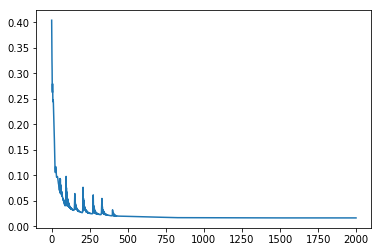


l Pre:  0.015506455674767494 l Exact:  0.003183098861837907
Times: 1 
 Mean f loss: 5.000e-02
[Epoch 0/2000] [loss: 0.017410438507795334] l pre: [0.014506456442177296]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.04049665108323097] l pre: [0.01671743579208851]
[Epoch 200/2000] [loss: 0.020620718598365784] l pre: [0.01695888862013817]
[Epoch 300/2000] [loss: 0.015829790383577347] l pre: [0.01582981087267399]
[Epoch 400/2000] [loss: 0.016659289598464966] l pre: [0.01557524036616087]
[Epoch 500/2000] [loss: 0.01611512154340744] l pre: [0.015437725931406021]
[Epoch 600/2000] [loss: 0.015647608786821365] l pre: [0.015319880098104477]
[Epoch 700/2000] [loss: 0.015197133645415306] l pre: [0.015209095552563667]
[Epoch 800/2000] [loss: 0.01475354004651308] l pre: [0.015100180171430111]
[Epoch 900/2000] [loss: 0.014707616530358791] l pre: [0.015088682062923908]
[Epoch 1000/2000] [loss: 0.014658129774034023] l pre: [0.015076255425810814]
model saved at [Epoch 1001/2000]
[Epoch 1100/20

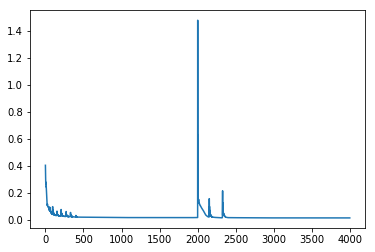


l Pre:  0.015041083097457886 l Exact:  0.003183098861837907
Times: 2 
 Mean f loss: 4.386e-02
[Epoch 0/2000] [loss: 0.015124152414500713] l pre: [0.014041082933545113]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.026654938235878944] l pre: [0.017750009894371033]
[Epoch 200/2000] [loss: 0.015269682742655277] l pre: [0.01751089282333851]
[Epoch 300/2000] [loss: 0.016083242371678352] l pre: [0.016172554343938828]
[Epoch 400/2000] [loss: 0.009185601957142353] l pre: [0.015164564363658428]
[Epoch 500/2000] [loss: 0.008870957419276237] l pre: [0.01500310655683279]
[Epoch 600/2000] [loss: 0.008539257571101189] l pre: [0.014820572920143604]
[Epoch 700/2000] [loss: 0.008196654729545116] l pre: [0.014618554152548313]
[Epoch 800/2000] [loss: 0.007848589681088924] l pre: [0.014400411397218704]
[Epoch 900/2000] [loss: 0.007812341675162315] l pre: [0.014376522973179817]
[Epoch 1000/2000] [loss: 0.007773283869028091] l pre: [0.014350585639476776]
model saved at [Epoch 1001/2000]
[Epoch 11

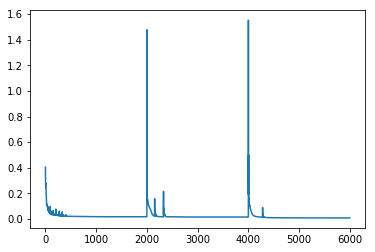


l Pre:  0.014276580885052681 l Exact:  0.003183098861837907
Times: 3 
 Mean f loss: 2.934e-02
[Epoch 0/2000] [loss: 0.008019326254725456] l pre: [0.013276580721139908]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.0074917590245604515] l pre: [0.014028048142790794]
[Epoch 200/2000] [loss: 0.005639511160552502] l pre: [0.01271099504083395]
[Epoch 300/2000] [loss: 0.004939937498420477] l pre: [0.01192997582256794]
[Epoch 400/2000] [loss: 0.017153862863779068] l pre: [0.010694180615246296]
[Epoch 500/2000] [loss: 0.003446926362812519] l pre: [0.010952015407383442]
[Epoch 600/2000] [loss: 0.003319610608741641] l pre: [0.010851426050066948]
[Epoch 700/2000] [loss: 0.003204955253750086] l pre: [0.010704404674470425]
[Epoch 800/2000] [loss: 0.0030889883637428284] l pre: [0.01054245326668024]
[Epoch 900/2000] [loss: 0.003076869761571288] l pre: [0.010524840094149113]
[Epoch 1000/2000] [loss: 0.003063801908865571] l pre: [0.01050574705004692]
model saved at [Epoch 1001/2000]
[Epoch 11

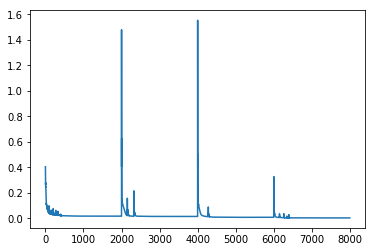


l Pre:  0.010451425798237324 l Exact:  0.003183098861837907
Times: 4 
 Mean f loss: 1.661e-02
[Epoch 0/2000] [loss: 0.003117916639894247] l pre: [0.011451425962150097]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.008844051510095596] l pre: [0.011166107840836048]
[Epoch 200/2000] [loss: 0.003505880944430828] l pre: [0.010865909047424793]
[Epoch 300/2000] [loss: 0.013672661036252975] l pre: [0.010038919746875763]
[Epoch 400/2000] [loss: 0.0026178264524787664] l pre: [0.010143730789422989]
[Epoch 500/2000] [loss: 0.0025705164298415184] l pre: [0.01005234383046627]
[Epoch 600/2000] [loss: 0.002519749803468585] l pre: [0.009952854365110397]
[Epoch 700/2000] [loss: 0.0024654443841427565] l pre: [0.009845194406807423]
[Epoch 800/2000] [loss: 0.0024080926086753607] l pre: [0.00973119493573904]
[Epoch 900/2000] [loss: 0.002401976613327861] l pre: [0.009718854911625385]
[Epoch 1000/2000] [loss: 0.002395357470959425] l pre: [0.009705476462841034]
model saved at [Epoch 1001/2000]
[Epoc

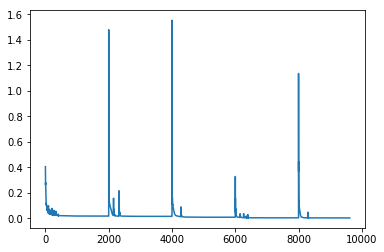


l Pre:  0.009668348357081413 l Exact:  0.003183098861837907
Times: 5 
 Mean f loss: 1.317e-02
[Epoch 0/2000] [loss: 0.002436882583424449] l pre: [0.00866835005581379]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.008813858963549137] l pre: [0.011788289994001389]
[Epoch 200/2000] [loss: 0.004748858045786619] l pre: [0.01128294039517641]
[Epoch 300/2000] [loss: 0.003102363320067525] l pre: [0.010511299595236778]
[Epoch 400/2000] [loss: 0.0029610658530145884] l pre: [0.010083725675940514]
[Epoch 500/2000] [loss: 0.002414150396361947] l pre: [0.010055862367153168]
[Epoch 600/2000] [loss: 0.002357184886932373] l pre: [0.00995621457695961]
[Epoch 700/2000] [loss: 0.002302451990544796] l pre: [0.009836484678089619]
[Epoch 800/2000] [loss: 0.002245530253276229] l pre: [0.00970825832337141]
[Epoch 900/2000] [loss: 0.0022394820116460323] l pre: [0.009694406762719154]
[Epoch 1000/2000] [loss: 0.0022329390048980713] l pre: [0.009679408743977547]
model saved at [Epoch 1001/2000]
[Epoch 1

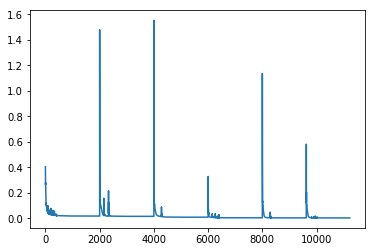


l Pre:  0.009637860581278801 l Exact:  0.003183098861837907
Times: 6 
 Mean f loss: 1.186e-02
[Epoch 0/2000] [loss: 0.002274296712130308] l pre: [0.010637860745191574]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.006569506600499153] l pre: [0.010670671239495277]
[Epoch 200/2000] [loss: 0.0029860378708690405] l pre: [0.010296720080077648]
[Epoch 300/2000] [loss: 0.0025707369204610586] l pre: [0.010045542381703854]
[Epoch 400/2000] [loss: 0.004455587361007929] l pre: [0.009468176402151585]
[Epoch 500/2000] [loss: 0.0024447720497846603] l pre: [0.009636521339416504]
[Epoch 600/2000] [loss: 0.002278044819831848] l pre: [0.009593624621629715]
[Epoch 700/2000] [loss: 0.0022049257531762123] l pre: [0.009503142908215523]
[Epoch 800/2000] [loss: 0.002146077109500766] l pre: [0.009397760033607483]
[Epoch 900/2000] [loss: 0.0021401927806437016] l pre: [0.00938624981790781]
[Epoch 1000/2000] [loss: 0.0021338672377169132] l pre: [0.009373784065246582]
model saved at [Epoch 1001/2000]
[E

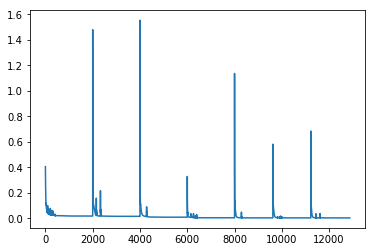


l Pre:  0.00933915562927723 l Exact:  0.003183098861837907
Times: 7 
 Mean f loss: 1.231e-02
[Epoch 0/2000] [loss: 0.002161063253879547] l pre: [0.008339155465364456]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.0058035277761518955] l pre: [0.01082002092152834]
[Epoch 200/2000] [loss: 0.002896420191973448] l pre: [0.010280479677021503]
[Epoch 300/2000] [loss: 0.010371376760303974] l pre: [0.009397238492965698]
[Epoch 400/2000] [loss: 0.0020671291276812553] l pre: [0.009497356601059437]
[Epoch 500/2000] [loss: 0.0020322806667536497] l pre: [0.009424488060176373]
[Epoch 600/2000] [loss: 0.001994938589632511] l pre: [0.009342554956674576]
[Epoch 700/2000] [loss: 0.0019550893921405077] l pre: [0.009253529831767082]
[Epoch 800/2000] [loss: 0.0019131163135170937] l pre: [0.009159175679087639]
[Epoch 900/2000] [loss: 0.0019086467800661922] l pre: [0.009148960933089256]
[Epoch 1000/2000] [loss: 0.0019038114696741104] l pre: [0.009137887507677078]
model saved at [Epoch 1001/2000]
[E

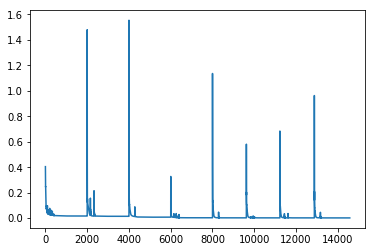


l Pre:  0.009106982499361038 l Exact:  0.003183098861837907
Times: 8 
 Mean f loss: 1.100e-02
[Epoch 0/2000] [loss: 0.0019139745272696018] l pre: [0.010106981731951237]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.009079117327928543] l pre: [0.009977053850889206]
[Epoch 200/2000] [loss: 0.002663541119545698] l pre: [0.01015049684792757]
[Epoch 300/2000] [loss: 0.006067753303796053] l pre: [0.009627768769860268]
[Epoch 400/2000] [loss: 0.0019482257775962353] l pre: [0.009317334741353989]
[Epoch 500/2000] [loss: 0.0019226855365559459] l pre: [0.009262765757739544]
[Epoch 600/2000] [loss: 0.0018948301440104842] l pre: [0.00920158065855503]
[Epoch 700/2000] [loss: 0.0018645904492586851] l pre: [0.009134378284215927]
[Epoch 800/2000] [loss: 0.001832194859161973] l pre: [0.009062220342457294]
[Epoch 900/2000] [loss: 0.0018287127604708076] l pre: [0.009054337628185749]
[Epoch 1000/2000] [loss: 0.0018249370623379946] l pre: [0.00904578436166048]
model saved at [Epoch 1001/2000]
[Ep

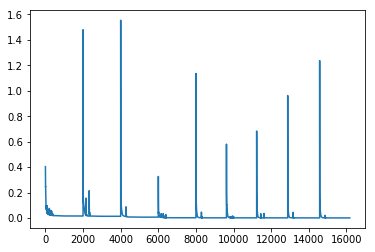


l Pre:  0.00902197603136301 l Exact:  0.003183098861837907
Times: 9 
 Mean f loss: 9.945e-03
[Epoch 0/2000] [loss: 0.0018327385187149048] l pre: [0.010021974332630634]
model saved at [Epoch 1/2000]
[Epoch 100/2000] [loss: 0.011392158456146717] l pre: [0.009860561229288578]
[Epoch 200/2000] [loss: 0.0031033537816256285] l pre: [0.010251207277178764]
[Epoch 300/2000] [loss: 0.002496139146387577] l pre: [0.010031895712018013]
[Epoch 400/2000] [loss: 0.0027282810769975185] l pre: [0.009653367102146149]
[Epoch 500/2000] [loss: 0.0022120019420981407] l pre: [0.009645017795264721]
[Epoch 600/2000] [loss: 0.002169938525184989] l pre: [0.009609674103558064]
[Epoch 700/2000] [loss: 0.0021335771307349205] l pre: [0.009557409211993217]
[Epoch 800/2000] [loss: 0.0020975510124117136] l pre: [0.009495643898844719]
[Epoch 900/2000] [loss: 0.0020937761291861534] l pre: [0.009488710202276707]
[Epoch 1000/2000] [loss: 0.0020896936766803265] l pre: [0.009481159970164299]
model saved at [Epoch 1001/2000]


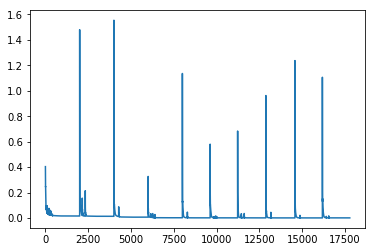


l Pre:  0.009460030123591423 l Exact:  0.003183098861837907
Times: 10 
 Mean f loss: 1.036e-02


In [8]:
# gpinns + RAR
for i in range(10):
    Losses = train(2000, Losses)
    N_f_rar = 50000
    lb = np.array([-1,0])
    ub = np.array([ 1,1])
    X_f_rar = lb + (ub-lb)*lhs(2,N_f_rar)
    X = torch.tensor(X_f_rar[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    T = torch.tensor(X_f_rar[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    f_pre, _, _= gf_function(X, T, l)
    err_eq = torch.abs(f_pre)
    err = torch.mean(err_eq)
    print('Times:',i+1,'\n',"Mean f loss: %.3e" % (err.item()))
    
    x_ids = torch.topk(err_eq, 100, dim=0)[1].numpy()
    for elem in x_ids:
        X_f_train = np.vstack((X_f_rar[elem],X_f_train))
    x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


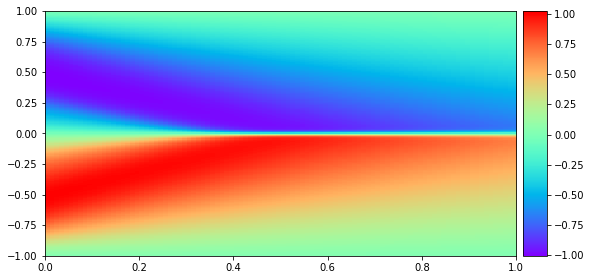

In [9]:
# 可视化
x = torch.linspace(-1, 1, 200, dtype=torch.float32)
t = torch.linspace( 0, 1, 100, dtype=torch.float32)
X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = u_function(xcol, tcol).reshape(x.numel(), t.numel())
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='rainbow', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()

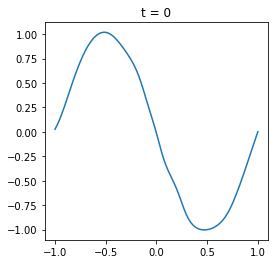

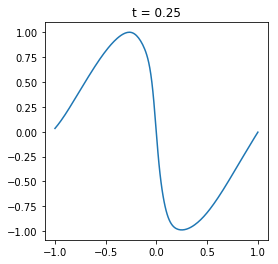

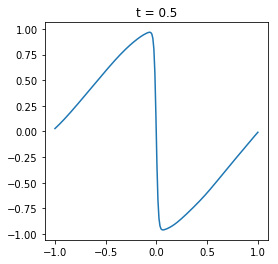

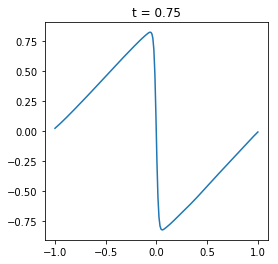

In [10]:
def plot_t(m):
    x = torch.linspace(-1, 1, 200, dtype=torch.float32)
    t = torch.full_like(x, m, dtype=torch.float32)
    X, T = torch.meshgrid(x, t)
    xcol = X.reshape(-1, 1)
    tcol = T.reshape(-1, 1)
    u_pre = u_function(xcol, tcol).detach().numpy().reshape(-1, 1)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(xcol,u_pre)
    title = 't = ' + str(m)
    plt.title(title)
    plt.show()
plot_t(0)
plot_t(0.25)
plot_t(0.5)
plot_t(0.75)

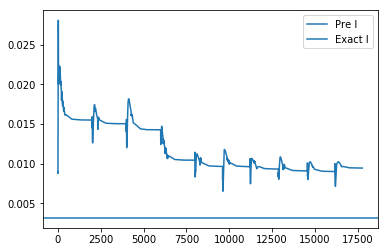

In [11]:
plt.plot(L,label='Pre l')
plt.axhline(y=nu,label='Exact l')
plt.legend()
plt.show()

# 真实解

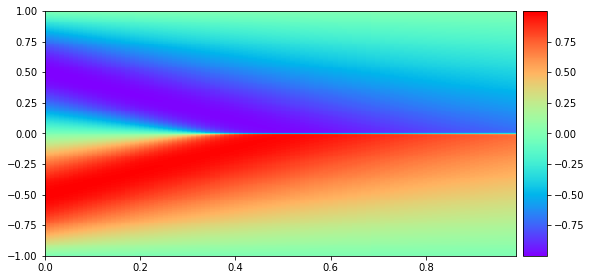

In [12]:
n=25600
xx,tt,uu=get_data(n)
if n != 0:
    xnp = xx.reshape(100,256).T
    tnp = tt.reshape(100,256).T
    Unp = uu.reshape(100,256).T
    # plot:
    fig = plt.figure(figsize=(9, 4.5))
    ax = fig.add_subplot(111)

    h = ax.imshow(Unp,
                  interpolation='nearest',
                  cmap='rainbow', 
                  extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=10)
    plt.show()